# Introduction
The purpose of this notebook is to create Custom Transformers to include this steps into a Pipeline.

## Set environment

In [57]:
# 
import pandas as pd
import numpy as np
import pingouin as pg
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats

# 
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# warnings
import warnings
warnings.filterwarnings("ignore")

## Import data

In [58]:
listings = pd.read_csv('listings_detailed.csv')

In [59]:
keep_cols = ['minimum_nights', 'maximum_nights', 'host_is_superhost']
host_cols = [col for col in listings.columns if 'host' in col if col not in keep_cols]
night_cols = [col for col in listings.columns if 'nights' in col if col not in keep_cols]
other_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 
              'picture_url', 'availability_30', 'availability_60', 'availability_90', 
              'first_review', 'last_review', 'license', 'number_of_reviews_ltm',
              'number_of_reviews_l30d', 'calendar_last_scraped', 'neighborhood_overview',
              'neighbourhood', 'has_availability', 'amenities', 'host_id', 'id', 'property_type']

# empty columns
mask_empty_cols = listings.isnull().sum() == len(listings)
empty_cols = listings.columns[mask_empty_cols].to_list()

# columns to drop
cols_drop = host_cols + other_cols + night_cols + empty_cols

# drop columns
listings.drop(columns=cols_drop, inplace=True)

We are going to remove 'bathroom_text', as we plan to create a new feature that encodes the number of bathrooms and if it is shared or not. We cannot include this in the Custom Transformer as it will raise an error when trying to predict based on train_X, as it will be looking for the column 'bathroom_text'in the Custom Transformer, but it would be already dropped. So as we are only going to transform the data (we do not need the Custom Transformer to learn from the data) we will do this as a pre-processing step before splitting into train and test sets.

In [60]:
def preprocess(df):

    # masks bathroom type
    shared_bathroom = (df['bathrooms_text'].str.contains('shared')) | (df['bathrooms_text'].str.contains('Shared'))
    half_bathroom = df['bathrooms_text'].str.contains('half-bath')
    
    # initiate 'bathroom type' with default value
    df['bathroom_type'] = 'no shared'
    # change values based on condition
    df.loc[shared_bathroom, 'bathroom_type'] = 'shared'

    # number of bathrooms (numeric)
    df['bathrooms'] = df['bathrooms_text'].str.extract('(\d+(?:\.\d+)?)', expand=False)
    df.loc[half_bathroom, 'bathrooms'] = 0.5
    df['bathrooms'] = df['bathrooms'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    # drop uneccesary column
    df.drop(columns='bathrooms_text', inplace=True)
    
    return df

In [61]:
listings = preprocess(listings)

Split into predictors (X) and target variable (y)

In [62]:
X = listings.drop(columns='price')
y = listings['price'].str.replace(',', '').str.slice(start=1).apply(lambda x: pd.to_numeric(x, errors='coerce'))

Split into train (70%) and test sets (30%)

Let's transform the target variable to be normally distributed

In [63]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.3, random_state=42)

print('X train and test sets shapes: ' + str(train_X.shape), str(test_X.shape), 
      '\ny train and test sets shapes: ' + str(train_y.shape), str(test_y.shape))

# reset index for further preprocessing
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

X train and test sets shapes: (3702, 23) (1587, 23) 
y train and test sets shapes: (3702,) (1587,)


As Sklearn does not allow to modify target variables, we will perform outlier removal as a preprocessing step before fitting the Pipeline. We will see how the model performs with outliers present or absent in the data. We will also implement standardization to minimize the impact of outliers in the model. In any case, outliers will be only removed computing the IQR based on the train set, using the lower and upper limit computed from the train set to remove outleirs from the test set.

In [64]:
def iqr_outlier_removal(train_X, test_X, train_y, test_y):
    """
    Compute Tukey's Interquantile Range (IQR) based on the
    train set. Stores Q1 and Q3, as well as IQR from the
    train sets and applies them to remove outliers from the
    test set.
    
    Input:
        dv: numeric variable as a pandas Series.
    Output:
        outlier: value of the outlier in the dv.
        outlier_loc: index of the outlier.
    """
    
    Q1, Q3 = np.percentile(train_y, [25, 75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR 
    upper_limit = Q3 + 1.5 * IQR 
    
    # store outliers and its location in the df
    outlier_train = []
    outlier_loc_train = []
    for i, x in enumerate(train_y): 
        if ((x > upper_limit) or (x < lower_limit)): 
            outlier_train.append(x)
            outlier_loc_train.append(i)
    
    # store outliers and its location in the df
    outlier_test = []
    outlier_loc_test = []
    for i, x in enumerate(test_y): 
        if ((x > upper_limit) or (x < lower_limit)): 
            outlier_test.append(x)
            outlier_loc_test.append(i)
            
    print('IQR is: ' + str(IQR) + ' with a lower limit: ' + str(lower_limit) + ' and a upper limit: ' + str(upper_limit) + '\n' +
          'In general we have: ' + str(len(outlier_train)) + ' outliers in the train dataset')
    print('In general we have: ' + str(len(outlier_test)) + ' outliers in the test dataset')
    
    # remove outliers
    train_X.drop(index=outlier_loc_train, inplace=True)
    train_X.reset_index(drop=True, inplace=True)
    train_y.drop(index=outlier_loc_train, inplace=True)
    train_y.reset_index(drop=True, inplace=True)
    
    test_X.drop(index=outlier_loc_test, inplace=True)
    test_X.reset_index(drop=True, inplace=True)
    test_y.drop(index=outlier_loc_test, inplace=True)
    test_y.reset_index(drop=True, inplace=True)
    
    return train_X, test_X, train_y, test_y

IQR is: 44.0 with a lower limit: -25.0 and a upper limit: 151.0
In general we have: 242 outliers in the train dataset
In general we have: 100 outliers in the test dataset


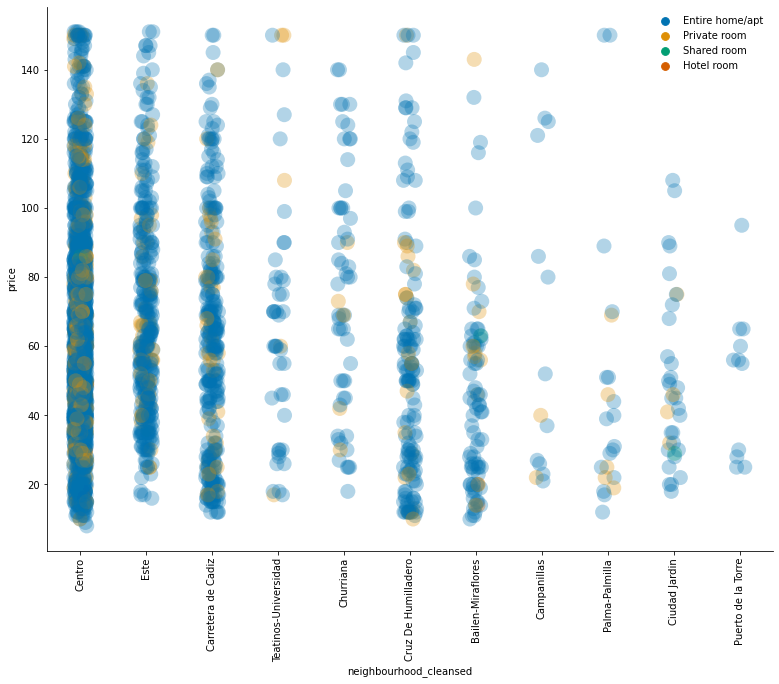

In [65]:
train_X, test_X, train_y, test_y = iqr_outlier_removal(train_X, test_X, train_y, test_y)

# plot
fig, ax = plt.subplots(figsize=(13, 10))
sns.stripplot(x=train_X['neighbourhood_cleansed'], y=train_y, palette='colorblind', hue=X['room_type'], size=15, alpha=.3)
plt.legend(frameon=False)
plt.xticks(rotation=90)
sns.despine()

We have seen that the model performs better when the target variable is normally distributed, although if we avoid transforming the target variable, that will make the interpretation easier, as we avoid reversing the transformation.

We are going to transform the target variable before introduce it into the Pipeline, in order to perform necessary steps before fitting the model.

We will also see how the model performs when we use the untransformed target variable in the previous steps to model fitting and only applying the transformation just before fitting the model using Sklearn TransformedTargetRegressor. In this case we will use Kruskal-Wallis for feature selection as the variable will not be normally distributed to apply ANOVA.

* The benefits of transforming the target variable can be checked in the following documentation: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

In [66]:
train_y_tr = np.sqrt(train_y)
test_y_tr = np.sqrt(test_y)

In [67]:
def plot_dist(df, dv_list=None, transformation=None):
    """
    Plot distribution of data. If required, a transformation
    of the data could be applied.
    
    Input:
        df: DataFrame
        dv_list: list of variables to be plotted.
        trasnformation (numpy): transformation that wants
                                to be applied to the data.
    Output:
        Distribution plot and probability plot of each variable.
    """
    
    
    if dv_list == None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
        
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df, fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df.dropna(), plot=ax[1])
        plt.show()
        
    elif dv_list != None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
            
        for dv in dv_list:
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
            stats.probplot(df[dv].dropna(), plot=ax[1])
            plt.show()

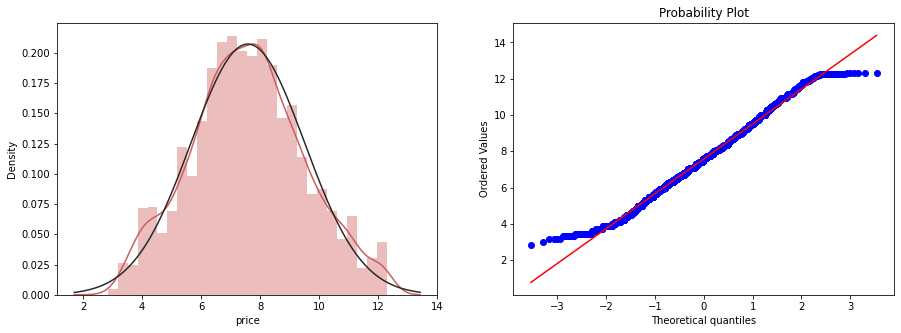

In [68]:
plot_dist(train_y_tr)

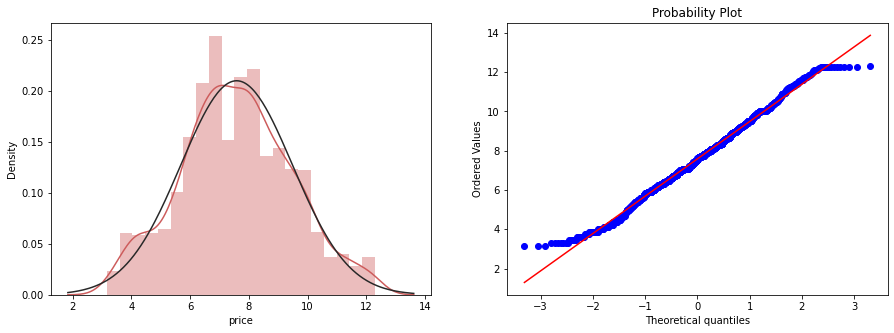

In [69]:
plot_dist(test_y_tr)

We see a high number of missing values in the review data. We are going to compute correlations to see possible patterns in the review scores based on other features in order to impute them. Although, no systematic correlations were found for the review scores, so we are going to impute the missing values just with the mean of the whole column.

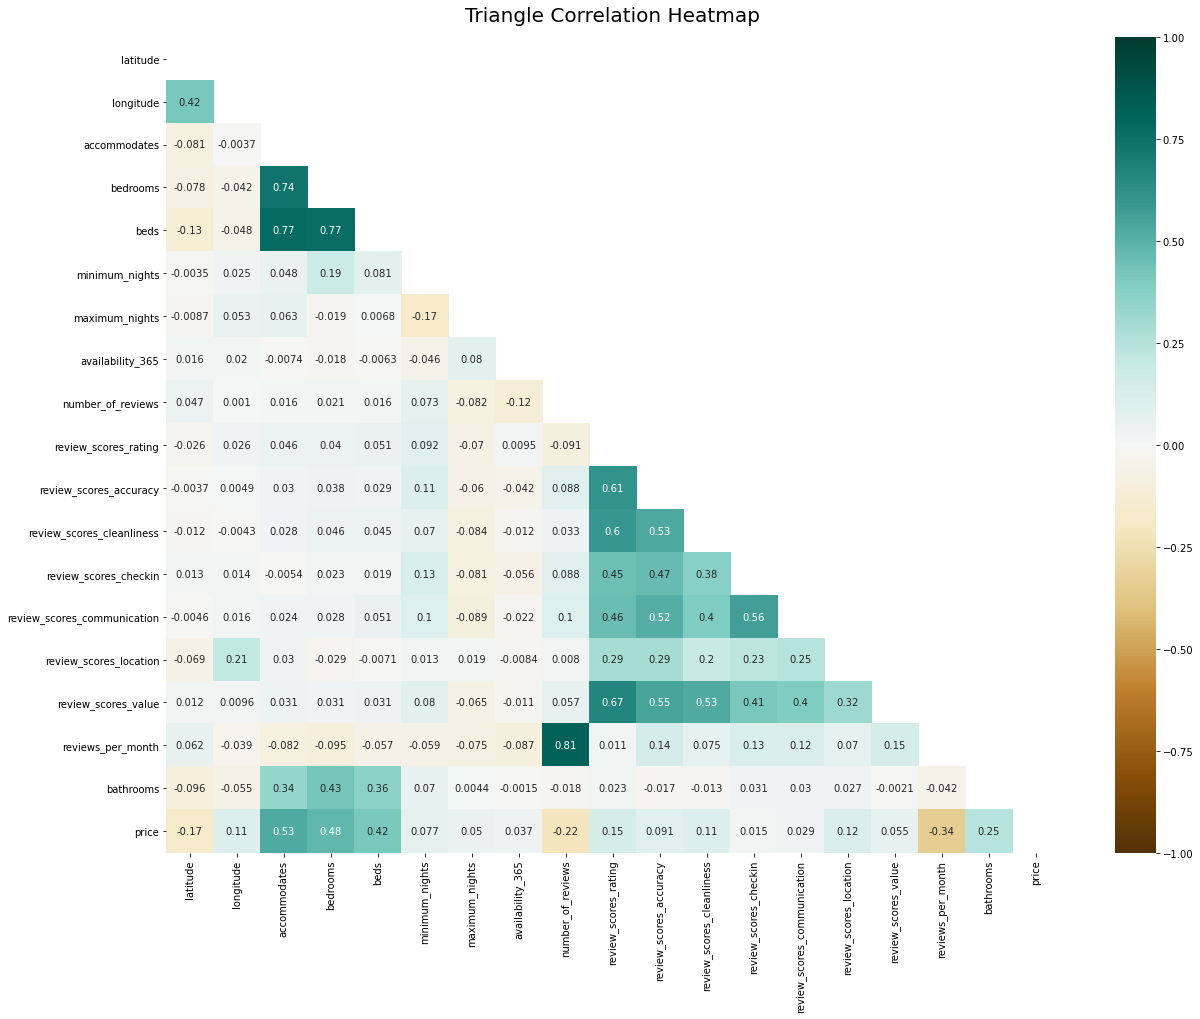

In [70]:
# concatenate the coded categorical variables with the predicted variable
train_coded = pd.concat([train_X, train_y_tr], axis=1)

# compute correlations
np.triu(np.ones_like(train_coded.corr(method='spearman')))
plt.figure(figsize=(20, 15))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_coded.corr(method='spearman'), dtype=np.bool))
heatmap = sns.heatmap(train_coded.corr(method='spearman'), mask=mask, vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

# Analysis/Modeling
Do work here

In [71]:
class CustomTransformerFeatures(TransformerMixin):
    
    def __init__(self):
        super().__init__()
        print('Transforming data. In the CustomTransformerFeatures init method: ')

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # masks sizes
        size_1 = (X['accommodates'] <= 3)
        size_2 = (X['accommodates'] >= 4) & (X['accommodates'] <= 7)
        size_3 = (X['accommodates'] >= 8) & (X['accommodates'] <= 20)
        
        # initiate new columns
        X['size'] = ''
        
        # sizes
        X.loc[size_1, 'size'] = 'small'
        X.loc[size_2, 'size'] = 'medium'
        X.loc[size_3, 'size'] = 'large'
        
        return X

In [72]:
class CustomImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.acc_bedr = {}
        self.acc_beds = {}
        self.acc_bathr = {}
        self.columns_order = None
        print('Transforming data. In the CustomImputer init method: ')

    def fit(self, X, y=None):
        self.acc_bedr = X.groupby(['accommodates'])['bedrooms'].mean()
        self.acc_beds = X.groupby(['accommodates'])['beds'].mean()
        self.acc_bathr = X.groupby(['accommodates'])['bathrooms'].mean()
        self.imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.imp_mean.fit(X.select_dtypes(include=[float, int]))
        self.columns_order = X.columns
        return self

    def transform(self, X, y=None):
        # apply values based on dictionaries 
        for (key_bedr, value_bedr), (key_beds, value_beds), (key_bathr, value_bathr) in zip(self.acc_bedr.items(), 
                                                                                            self.acc_beds.items(), 
                                                                                            self.acc_bathr.items()):
            
            X.loc[((X['bedrooms'].isnull()) & (X['accommodates'] == key_bedr)), 'bedrooms'] = value_bedr
            X.loc[((X['beds'].isnull()) & (X['accommodates'] == key_beds)), 'beds'] = value_beds
            X.loc[((X['bathrooms'].isnull()) & (X['accommodates'] == key_bathr)), 'bathrooms'] = value_bathr
        
        # impute missing values only in numeric columns
        X_imp_mean = pd.DataFrame(data=self.imp_mean.transform(X.select_dtypes(include=[float, int])), 
                                  index=X.index, 
                                  columns=X.select_dtypes(include=[float, int]).columns)
        # concatenate both DataFrames
        X = pd.concat([X.select_dtypes(exclude=['float', 'int']), X_imp_mean], axis=1)
        
        # set columns original order
        X = X.reindex(columns=self.columns_order)
        
        return X

As we have transformed the target variable to be normally distributed, we will use ANOVA to select categorical features. In case we do not want to transform the target variable, we can use Kruskal-Wallis.

In [93]:
class FeatureSelectionANOVA(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.cat_features = None
        self.drop_features = []
        print('Transforming data. In the FeatureSelectionANOVA init method: ')

    def fit(self, X, y):
        self.cat_features = X.select_dtypes(include=object).columns.to_list()
        df = pd.concat([X, y], axis=1)
        
        for feature in self.cat_features:
            p_value = pg.anova(data=df, dv=y.name, between=feature, detailed=True, effsize='np2')['p-unc'].iloc[0]
            if p_value > .05:
                self.drop_features.append(feature)

        return self
    
    def transform(self, X, y=None):
        X.drop(columns=self.drop_features, inplace=True)
        
        return X

In [94]:
class FeatureSelectionKruskal(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.cat_features = None
        self.drop_features = []
        print('Transforming data. In the FeatureSelectionKruskal init method: ')

    def fit(self, X, y):
        self.cat_features = X.select_dtypes(include=object).columns.to_list()
        df = pd.concat([X, y], axis=1)
        
        for feature in self.cat_features:
            p_value = pg.kruskal(data=df, dv=y.name, between=feature, detailed=True)['p-unc'].iloc[0]
            if p_value > .05:
                self.drop_features.append(feature)

        return self
    
    def transform(self, X, y=None):
        X.drop(columns=self.drop_features, inplace=True)
        
        return X

In [86]:
class CustomOrdinal(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories, target_column):
        super().__init__()
        self.categories = categories
        self.target_column = target_column
        self.encoder = OrdinalEncoder(categories=[self.categories])
        print('Transforming data. In the CustomOrdinal init method: ')

    def fit(self, X, y=None):              
        self.encoder.fit(X[self.target_column].values.reshape(-1, 1))
        return self
    
    def transform(self, X, y=None):
        X[self.target_column] = self.encoder.transform(X[self.target_column].values.reshape(-1, 1))
        
        return X

In [75]:
class CustomDummy(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        print('Transforming data. In the CustomDummy init method: ')

    def fit(self, X, y=None):
        X_dummies = pd.get_dummies(X, drop_first=True)
        self.dummies = X_dummies.columns
                
        return self
    
    def transform(self, X, y=None):
        X_dummies = pd.get_dummies(X)
        X = X_dummies.reindex(columns=self.dummies, fill_value=0)
        
        return X

In [76]:
class MulticollinearityVIF(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.vif = pd.DataFrame()
        self.removed_features = []
        print('Transforming data. In the MulticollinearityVIF init method: ')

    def fit(self, X, y=None):
        self.vif['variables'] = X.columns
        self.vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        self.vif.sort_values(by='VIF', ascending=False, inplace=True)
        
        # deep copy of the original VIF values
        vif_original = self.vif.copy(deep=True)
        
        # iterate and removed VIF values greater or equal to 10
        while self.vif['VIF'].iloc[0] >= 10:
            X.drop(columns=self.vif['variables'].iloc[0], inplace=True)
            self.removed_features.append(self.vif['variables'].iloc[0])
            self.vif = pd.DataFrame()
            self.vif['variables'] = X.columns
            self.vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            self.vif.sort_values(by='VIF', ascending=False, inplace=True)
                
        return self
    
    def transform(self, X, y=None):
        X = X[X.columns[~X.columns.isin(self.removed_features)]]
        
        return X

In [77]:
class CustomStandardizer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.not_dummy_cols = None
        self.scaler = StandardScaler()
        print('Transforming data. In the CustomStandardizer init method: ')

    def fit(self, X, y=None):
        # list of not dummy cols
        self.not_dummy_cols = X.select_dtypes(exclude='uint8').columns.to_list()
        self.scaler.fit(X[self.not_dummy_cols])
        
        return self
    
    def transform(self, X, y=None):
        # dummy cols df
        X_dummy = X.drop(columns=self.not_dummy_cols).reset_index(drop=True)
        # standardize not dummy cols
        X_scaled = self.scaler.transform(X[self.not_dummy_cols])
        X_scaled = pd.DataFrame(data=X_scaled, columns=X[self.not_dummy_cols].columns)
        
        X = pd.concat([X_scaled, X_dummy], axis=1)
        
        return X

In [78]:
class CustomRandomForestSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.model = RandomForestRegressor(max_depth=10)
        self.selected_features = None
        print('Transforming data. In the CustomRandomForestSelector init method: ')

    def fit(self, X, y):
        self.model.fit(X, y)
        feat_importances = pd.Series(self.model.feature_importances_, index=X.columns)
        #display(feat_importances.sort_values(ascending=False))
        self.selected_features = feat_importances.sort_values(ascending=False).nlargest(10).index.to_list()
        print('10 selected features: ')
        display(self.selected_features)
        return self
    
    def transform(self, X, y=None):
        X = X[X.columns[X.columns.isin(self.selected_features)]]
        
        return X

### Transformers

In [138]:
CustomTransformerFeatures_imp = CustomTransformerFeatures()
CustomImputer_imp = CustomImputer()
FSel_trans = FeatureSelectionANOVA()
Ordinal = CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')
Dummy = CustomDummy()
MultVIF = MulticollinearityVIF()
Stand = CustomStandardizer()
RFfeature = CustomRandomForestSelector()

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


### Train set

In [139]:
X_feat = CustomTransformerFeatures_imp.fit_transform(train_X)

In [140]:
X_feat.head()

,host_is_superhost,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,bathroom_type,bathrooms,size
0,f,Centro,36.72602,-4.42028,Entire home/apt,8,4.0,6.0,1,1125,...,NaN,NaN,NaN,NaN,NaN,t,NaN,no shared,2.0,large
1,f,Este,36.71792,-4.34880,Entire home/apt,6,3.0,5.0,3,1124,...,10.0,10.0,10.0,10.0,9.0,t,0.31,no shared,1.0,medium
2,f,Centro,36.71084,-4.42777,Entire home/apt,6,3.0,6.0,1,1125,...,8.0,8.0,8.0,8.0,6.0,t,0.13,no shared,2.0,medium
3,f,Centro,36.72371,-4.42494,Entire home/apt,3,1.0,2.0,1,1125,...,9.0,10.0,10.0,10.0,8.0,t,0.12,no shared,1.0,small
4,f,Centro,36.72912,-4.42023,Entire home/apt,6,3.0,5.0,4,60,...,10.0,10.0,10.0,10.0,9.0,t,2.95,no shared,1.0,medium


In [141]:
X_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            3460 non-null   object 
 1   neighbourhood_cleansed       3460 non-null   object 
 2   latitude                     3460 non-null   float64
 3   longitude                    3460 non-null   float64
 4   room_type                    3460 non-null   object 
 5   accommodates                 3460 non-null   int64  
 6   bedrooms                     3168 non-null   float64
 7   beds                         3442 non-null   float64
 8   minimum_nights               3460 non-null   int64  
 9   maximum_nights               3460 non-null   int64  
 10  availability_365             3460 non-null   int64  
 11  number_of_reviews            3460 non-null   int64  
 12  review_scores_rating         2771 non-null   float64
 13  review_scores_accu

In [142]:
X_feat_imp = CustomImputer_imp.fit_transform(X_feat)

In [143]:
X_feat_imp.head()

,host_is_superhost,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,bathroom_type,bathrooms,size
0,f,Centro,36.72602,-4.42028,Entire home/apt,8,4.0,6.0,1,1125,...,9.416817,9.670155,9.658246,9.58607,9.235294,t,1.247669,no shared,2.0,large
1,f,Este,36.71792,-4.34880,Entire home/apt,6,3.0,5.0,3,1124,...,10.000000,10.000000,10.000000,10.00000,9.000000,t,0.310000,no shared,1.0,medium
2,f,Centro,36.71084,-4.42777,Entire home/apt,6,3.0,6.0,1,1125,...,8.000000,8.000000,8.000000,8.00000,6.000000,t,0.130000,no shared,2.0,medium
3,f,Centro,36.72371,-4.42494,Entire home/apt,3,1.0,2.0,1,1125,...,9.000000,10.000000,10.000000,10.00000,8.000000,t,0.120000,no shared,1.0,small
4,f,Centro,36.72912,-4.42023,Entire home/apt,6,3.0,5.0,4,60,...,10.000000,10.000000,10.000000,10.00000,9.000000,t,2.950000,no shared,1.0,medium


In [144]:
X_feat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            3460 non-null   object 
 1   neighbourhood_cleansed       3460 non-null   object 
 2   latitude                     3460 non-null   float64
 3   longitude                    3460 non-null   float64
 4   room_type                    3460 non-null   object 
 5   accommodates                 3460 non-null   int64  
 6   bedrooms                     3460 non-null   float64
 7   beds                         3460 non-null   float64
 8   minimum_nights               3460 non-null   int64  
 9   maximum_nights               3460 non-null   int64  
 10  availability_365             3460 non-null   int64  
 11  number_of_reviews            3460 non-null   int64  
 12  review_scores_rating         3460 non-null   float64
 13  review_scores_accu

In [145]:
X_feat_imp_sel = FSel_trans.fit_transform(X_feat_imp, train_y)

0.11570627148567335

,Source,SS,DF,MS,F,p-unc,np2
0,host_is_superhost,9.181698,1,9.181698,2.475743,0.115706,0.000715
1,Within,12824.557873,3458,3.708663,NaN,NaN,NaN


7.80729267070631e-17

,Source,SS,DF,MS,F,p-unc,np2
0,neighbourhood_cleansed,363.522235,10,36.352223,10.054261,7.807293e-17,0.028326
1,Within,12470.217336,3449,3.615604,NaN,NaN,NaN


4.2074263420290757e-200

,Source,SS,DF,MS,F,p-unc,np2
0,room_type,3012.002315,3,1004.000772,353.280339,4.207426e-200,0.234694
1,Within,9821.737256,3456,2.841938,NaN,NaN,NaN


0.04789169842956161

,Source,SS,DF,MS,F,p-unc,np2
0,instant_bookable,14.519174,1,14.519174,3.916564,0.047892,0.001131
1,Within,12819.220397,3458,3.707120,NaN,NaN,NaN


5.881635209718531e-187

,Source,SS,DF,MS,F,p-unc,np2
0,bathroom_type,2798.393367,1,2798.393367,964.276077,5.881635e-187,0.21805
1,Within,10035.346204,3458,2.902067,NaN,NaN,NaN


6.454806868184193e-201

,Source,SS,DF,MS,F,p-unc,np2
0,size,3004.136702,2,1502.068351,528.266539,6.454807e-201,0.234081
1,Within,9829.602869,3457,2.843391,NaN,NaN,NaN


['host_is_superhost']

In [146]:
X_feat_imp_sel.head()

,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,bathroom_type,bathrooms,size
0,Centro,36.72602,-4.42028,Entire home/apt,8,4.0,6.0,1,1125,63,...,9.416817,9.670155,9.658246,9.58607,9.235294,t,1.247669,no shared,2.0,large
1,Este,36.71792,-4.34880,Entire home/apt,6,3.0,5.0,3,1124,177,...,10.000000,10.000000,10.000000,10.00000,9.000000,t,0.310000,no shared,1.0,medium
2,Centro,36.71084,-4.42777,Entire home/apt,6,3.0,6.0,1,1125,365,...,8.000000,8.000000,8.000000,8.00000,6.000000,t,0.130000,no shared,2.0,medium
3,Centro,36.72371,-4.42494,Entire home/apt,3,1.0,2.0,1,1125,365,...,9.000000,10.000000,10.000000,10.00000,8.000000,t,0.120000,no shared,1.0,small
4,Centro,36.72912,-4.42023,Entire home/apt,6,3.0,5.0,4,60,309,...,10.000000,10.000000,10.000000,10.00000,9.000000,t,2.950000,no shared,1.0,medium


In [147]:
X_feat_imp_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighbourhood_cleansed       3460 non-null   object 
 1   latitude                     3460 non-null   float64
 2   longitude                    3460 non-null   float64
 3   room_type                    3460 non-null   object 
 4   accommodates                 3460 non-null   int64  
 5   bedrooms                     3460 non-null   float64
 6   beds                         3460 non-null   float64
 7   minimum_nights               3460 non-null   int64  
 8   maximum_nights               3460 non-null   int64  
 9   availability_365             3460 non-null   int64  
 10  number_of_reviews            3460 non-null   int64  
 11  review_scores_rating         3460 non-null   float64
 12  review_scores_accuracy       3460 non-null   float64
 13  review_scores_clea

In [148]:
X_feat_imp_sel_ord = Ordinal.fit_transform(X_feat_imp_sel)

In [149]:
X_feat_imp_sel_ord.head()

,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,bathroom_type,bathrooms,size
0,Centro,36.72602,-4.42028,Entire home/apt,8,4.0,6.0,1,1125,63,...,9.416817,9.670155,9.658246,9.58607,9.235294,t,1.247669,no shared,2.0,2.0
1,Este,36.71792,-4.34880,Entire home/apt,6,3.0,5.0,3,1124,177,...,10.000000,10.000000,10.000000,10.00000,9.000000,t,0.310000,no shared,1.0,1.0
2,Centro,36.71084,-4.42777,Entire home/apt,6,3.0,6.0,1,1125,365,...,8.000000,8.000000,8.000000,8.00000,6.000000,t,0.130000,no shared,2.0,1.0
3,Centro,36.72371,-4.42494,Entire home/apt,3,1.0,2.0,1,1125,365,...,9.000000,10.000000,10.000000,10.00000,8.000000,t,0.120000,no shared,1.0,0.0
4,Centro,36.72912,-4.42023,Entire home/apt,6,3.0,5.0,4,60,309,...,10.000000,10.000000,10.000000,10.00000,9.000000,t,2.950000,no shared,1.0,1.0


In [150]:
X_feat_imp_sel_ord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighbourhood_cleansed       3460 non-null   object 
 1   latitude                     3460 non-null   float64
 2   longitude                    3460 non-null   float64
 3   room_type                    3460 non-null   object 
 4   accommodates                 3460 non-null   int64  
 5   bedrooms                     3460 non-null   float64
 6   beds                         3460 non-null   float64
 7   minimum_nights               3460 non-null   int64  
 8   maximum_nights               3460 non-null   int64  
 9   availability_365             3460 non-null   int64  
 10  number_of_reviews            3460 non-null   int64  
 11  review_scores_rating         3460 non-null   float64
 12  review_scores_accuracy       3460 non-null   float64
 13  review_scores_clea

In [151]:
X_feat_imp_sel_ord_dummy = Dummy.fit_transform(X_feat_imp_sel_ord)

In [152]:
X_feat_imp_sel_ord_dummy.head()

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,...,neighbourhood_cleansed_Cruz De Humilladero,neighbourhood_cleansed_Este,neighbourhood_cleansed_Palma-Palmilla,neighbourhood_cleansed_Puerto de la Torre,neighbourhood_cleansed_Teatinos-Universidad,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t,bathroom_type_shared
0,36.72602,-4.42028,8,4.0,6.0,1,1125,63,0,92.519307,...,0,0,0,0,0,0,0,0,1,0
1,36.71792,-4.34880,6,3.0,5.0,3,1124,177,17,92.000000,...,0,1,0,0,0,0,0,0,1,0
2,36.71084,-4.42777,6,3.0,6.0,1,1125,365,1,60.000000,...,0,0,0,0,0,0,0,0,1,0
3,36.72371,-4.42494,3,1.0,2.0,1,1125,365,2,100.000000,...,0,0,0,0,0,0,0,0,1,0
4,36.72912,-4.42023,6,3.0,5.0,4,60,309,45,95.000000,...,0,0,0,0,0,0,0,0,1,0


In [153]:
X_feat_imp_sel_ord_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   latitude                                     3460 non-null   float64
 1   longitude                                    3460 non-null   float64
 2   accommodates                                 3460 non-null   int64  
 3   bedrooms                                     3460 non-null   float64
 4   beds                                         3460 non-null   float64
 5   minimum_nights                               3460 non-null   int64  
 6   maximum_nights                               3460 non-null   int64  
 7   availability_365                             3460 non-null   int64  
 8   number_of_reviews                            3460 non-null   int64  
 9   review_scores_rating                         3460 non-null   float64
 10  

In [154]:
X_feat_imp_sel_ord_dummy_vif = MultVIF.fit_transform(X_feat_imp_sel_ord_dummy)

In [155]:
X_feat_imp_sel_ord_dummy_vif.head()

,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,reviews_per_month,bathrooms,size,neighbourhood_cleansed_Campanillas,neighbourhood_cleansed_Carretera de Cadiz,...,neighbourhood_cleansed_Cruz De Humilladero,neighbourhood_cleansed_Este,neighbourhood_cleansed_Palma-Palmilla,neighbourhood_cleansed_Puerto de la Torre,neighbourhood_cleansed_Teatinos-Universidad,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t,bathroom_type_shared
0,6.0,1,1125,63,0,1.247669,2.0,2.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5.0,3,1124,177,17,0.310000,1.0,1.0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,6.0,1,1125,365,1,0.130000,2.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2.0,1,1125,365,2,0.120000,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5.0,4,60,309,45,2.950000,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [156]:
X_feat_imp_sel_ord_dummy_vif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   beds                                         3460 non-null   float64
 1   minimum_nights                               3460 non-null   int64  
 2   maximum_nights                               3460 non-null   int64  
 3   availability_365                             3460 non-null   int64  
 4   number_of_reviews                            3460 non-null   int64  
 5   reviews_per_month                            3460 non-null   float64
 6   bathrooms                                    3460 non-null   float64
 7   size                                         3460 non-null   float64
 8   neighbourhood_cleansed_Campanillas           3460 non-null   uint8  
 9   neighbourhood_cleansed_Carretera de Cadiz    3460 non-null   uint8  
 10  

In [157]:
X_feat_imp_sel_ord_dummy_vif_stand = Stand.fit_transform(X_feat_imp_sel_ord_dummy_vif)

In [158]:
X_feat_imp_sel_ord_dummy_vif_stand.head()

,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,reviews_per_month,bathrooms,size,neighbourhood_cleansed_Campanillas,neighbourhood_cleansed_Carretera de Cadiz,...,neighbourhood_cleansed_Cruz De Humilladero,neighbourhood_cleansed_Este,neighbourhood_cleansed_Palma-Palmilla,neighbourhood_cleansed_Puerto de la Torre,neighbourhood_cleansed_Teatinos-Universidad,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_t,bathroom_type_shared
0,2.223131,-0.202041,0.697242,-1.228676,-0.581340,-1.843915e-16,1.608196,2.379327,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.598847,-0.050909,0.695172,-0.346353,-0.276813,-7.786644e-01,-0.541544,0.576727,0,0,...,0,1,0,0,0,0,0,0,1,0
2,2.223131,-0.202041,0.697242,1.108706,-0.563426,-9.281411e-01,1.608196,0.576727,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-0.274006,-0.202041,0.697242,1.108706,-0.545513,-9.364453e-01,-0.541544,-1.225872,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.598847,0.024657,-1.507187,0.675285,0.224761,1.413659e+00,-0.541544,0.576727,0,0,...,0,0,0,0,0,0,0,0,1,0


In [159]:
X_feat_imp_sel_ord_dummy_vif_stand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   beds                                         3460 non-null   float64
 1   minimum_nights                               3460 non-null   float64
 2   maximum_nights                               3460 non-null   float64
 3   availability_365                             3460 non-null   float64
 4   number_of_reviews                            3460 non-null   float64
 5   reviews_per_month                            3460 non-null   float64
 6   bathrooms                                    3460 non-null   float64
 7   size                                         3460 non-null   float64
 8   neighbourhood_cleansed_Campanillas           3460 non-null   uint8  
 9   neighbourhood_cleansed_Carretera de Cadiz    3460 non-null   uint8  
 10  

In [160]:
X_feat_imp_sel_ord_dummy_vif_stand_RFsel = RFfeature.fit_transform(X_feat_imp_sel_ord_dummy_vif_stand, train_y)

room_type_Private room                         0.207972
size                                           0.138580
bathrooms                                      0.134388
reviews_per_month                              0.120729
minimum_nights                                 0.074213
bathroom_type_shared                           0.063824
number_of_reviews                              0.063615
availability_365                               0.062663
beds                                           0.053751
maximum_nights                                 0.031123
instant_bookable_t                             0.011495
neighbourhood_cleansed_Churriana               0.009029
neighbourhood_cleansed_Este                    0.007827
room_type_Shared room                          0.004520
neighbourhood_cleansed_Carretera de Cadiz      0.004457
neighbourhood_cleansed_Cruz De Humilladero     0.003019
neighbourhood_cleansed_Teatinos-Universidad    0.002718
room_type_Hotel room                           0

In [161]:
X_feat_imp_sel_ord_dummy_vif_stand_RFsel.head()

,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,reviews_per_month,bathrooms,size,room_type_Private room,bathroom_type_shared
0,2.223131,-0.202041,0.697242,-1.228676,-0.581340,-1.843915e-16,1.608196,2.379327,0,0
1,1.598847,-0.050909,0.695172,-0.346353,-0.276813,-7.786644e-01,-0.541544,0.576727,0,0
2,2.223131,-0.202041,0.697242,1.108706,-0.563426,-9.281411e-01,1.608196,0.576727,0,0
3,-0.274006,-0.202041,0.697242,1.108706,-0.545513,-9.364453e-01,-0.541544,-1.225872,0,0
4,1.598847,0.024657,-1.507187,0.675285,0.224761,1.413659e+00,-0.541544,0.576727,0,0


In [162]:
X_feat_imp_sel_ord_dummy_vif_stand_RFsel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   beds                    3460 non-null   float64
 1   minimum_nights          3460 non-null   float64
 2   maximum_nights          3460 non-null   float64
 3   availability_365        3460 non-null   float64
 4   number_of_reviews       3460 non-null   float64
 5   reviews_per_month       3460 non-null   float64
 6   bathrooms               3460 non-null   float64
 7   size                    3460 non-null   float64
 8   room_type_Private room  3460 non-null   uint8  
 9   bathroom_type_shared    3460 non-null   uint8  
dtypes: float64(8), uint8(2)
memory usage: 223.1 KB


# Models

## LASSO: find best hyperparameters

### GridSearchCV Pipeline - Target variable transformed beforehand

#### Pipeline

In [95]:
pipe_gs = Pipeline([('transform_features', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionANOVA()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('lasso_regressor', Lasso(random_state=42))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

To access the parameters of the estimator using Sklearn Pipeline we need to use the following sintax: 'estimator__parameter'. Hence, if our estimator is called 'lasso_regressor', to access the parameter alpha in the param_grid we will need to especify 'lasso_regressor__alpha'

In [96]:
param_grid = {'lasso_regressor__alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
folds = KFold(n_splits=5, shuffle=True, random_state=42)

#### GridSearchCV

In [97]:
lasso_cv_gs = GridSearchCV(estimator=pipe_gs, 
                        param_grid=param_grid, 
                        cv=folds,
                        scoring='neg_mean_squared_error',
                        refit=True)

#### Fit

In [98]:
lasso_cv_gs.fit(train_X, train_y_tr)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights']

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('transform_features',
                                        <__main__.CustomTransformerFeatures object at 0x000001409FA7C548>),
                                       ('impute', CustomImputer()),
                                       ('select_features_ANOVA',
                                        FeatureSelectionANOVA()),
                                       ('ordinal_encoder',
                                        CustomOrdinal(categories=['small',
                                                                  '...
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=42,
                            

In [99]:
y_predict_gs = lasso_cv_gs.predict(test_X)
y_predict_train_gs = lasso_cv_gs.predict(train_X)

In [100]:
lasso_best_params_gs = lasso_cv_gs.best_params_
lasso_best_score_gs = lasso_cv_gs.best_score_
print('Best parameters for Lasso Regression: ' + str(lasso_best_params_gs) + '\n' + 
      'Best score for Lasso Regression: ' + str(lasso_best_score_gs) + '\n')

Best parameters for Lasso Regression: {'lasso_regressor__alpha': 0.0}
Best score for Lasso Regression: -2.2480250029396593



In [101]:
# R squared
lasso_score_gs = lasso_cv_gs.score(test_X, test_y_tr)
lasso_score_train_gs = lasso_cv_gs.score(train_X, train_y_tr)
# MSE
mse_gs = mean_squared_error(test_y_tr, y_predict_gs)
mse_train_gs = mean_squared_error(train_y_tr, y_predict_train_gs)
# RMSE
rmse_gs = np.sqrt(mean_squared_error(test_y_tr, y_predict_gs))
rmse_train_gs = np.sqrt(mean_squared_error(train_y_tr, y_predict_train_gs))
#MAE
mae_gs = mean_absolute_error(test_y_tr, y_predict_gs)
mae_train_gs = mean_absolute_error(train_y_tr, y_predict_train_gs)

print('R Squared on test data: ' + str(lasso_score_gs) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(mse_gs) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse_gs) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae_gs) + '\n')

print('R Squared on train data: ' + str(lasso_score_train_gs) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(mse_train_gs) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train_gs) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mae_train_gs) + '\n')

R Squared on test data: -2.1627501085143255
Mean Squared Error (MSE) on test data: 2.1627501085143255
Root Mean Squared Error (RMSE) on test data: 1.4706291539726544
Mean Absolute Error (MAE) on test data: 1.156654987913084

R Squared on train data: -2.1647857289891377
Mean Squared Error (MSE) on train data: 2.1647857289891377
Root Mean Squared Error (RMSE) on train data: 1.4713210829010566
Mean Absolute Error (MAE) on train data: 1.1589575812226791



### GridSearch CV Pipeline - TransformedTargetRegressor

#### Pipeline

Transformation function to introduce into TransformedTargetRegressor

In [102]:
def func(x):
    return np.sqrt(x)

def inverse_func(x):
    return np.square(x)

In [103]:
pipe_ttr_gs = Pipeline([('transform_features', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionKruskal()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('lasso_regressor', TransformedTargetRegressor(regressor=Lasso(random_state=42),
                                                                   func=func, 
                                                                   inverse_func=inverse_func, 
                                                                   check_inverse=False))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

In [104]:
# funciona, Lasso is stored as regressor in the TransformedTargetRegressor, so to access the parameters we need to specify first
# lasso_regressor, as indicated in the Pipeline, then regressor for the TransformedTargetRegressor, and then the name
# of the parameter
param_grid_ttr_gs = {'lasso_regressor__regressor__alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
folds = KFold(n_splits=5, shuffle=True, random_state=42)

#### GridSearchCV

In [105]:
# funciona
lasso_ttr_gs = GridSearchCV(estimator=pipe_ttr_gs, 
                        param_grid=param_grid_ttr_gs, 
                        cv=folds,
                        scoring='neg_mean_squared_error',
                        refit=True)

#### Fit

In [106]:
# funciona
lasso_ttr_gs.fit(train_X, train_y)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathrooms',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'room_type_Private room',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'bathrooms',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'room_type_Private room',
 'maximum_nights']

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('transform_features',
                                        <__main__.CustomTransformerFeatures object at 0x000001409A9E4B48>),
                                       ('impute', CustomImputer()),
                                       ('select_features_ANOVA',
                                        FeatureSelectionKruskal()),
                                       ('ordinal_encoder',
                                        CustomOrdinal(categories=['small'...
                                                                                   positive=False,
                                                                                   precompute=False,
                                                                                   random_state=42,
                                    

In [107]:
lasso_best_params_ttr_gs = lasso_ttr_gs.best_params_
lasso_best_score_ttr_gs = lasso_ttr_gs.best_score_
print('Best parameters for Lasso Regression: ' + str(lasso_best_params_ttr_gs) + '\n' + 
      'Best score for Lasso Regression: ' + str(lasso_best_score_ttr_gs) + '\n')

Best parameters for Lasso Regression: {'lasso_regressor__regressor__alpha': 0.0}
Best score for Lasso Regression: -585.8180115604839



In [108]:
y_predict_ttr_gs = lasso_ttr_gs.predict(test_X)
y_predict_train_ttr_gs = lasso_ttr_gs.predict(train_X)

In [109]:
# R squared
lasso_score_ttr_gs = lasso_ttr_gs.score(test_X, test_y)
lasso_score_train_ttr_gs = lasso_ttr_gs.score(train_X, train_y)
# MSE
mse_ttr_gs = mean_squared_error(test_y, y_predict_ttr_gs)
mse_train_ttr_gs = mean_squared_error(train_y, y_predict_train_ttr_gs)
# RMSE
rmse_ttr_gs = np.sqrt(mean_squared_error(test_y, y_predict_ttr_gs))
rmse_train_ttr_gs = np.sqrt(mean_squared_error(train_y, y_predict_train_ttr_gs))
#MAE
mae_ttr_gs = mean_absolute_error(test_y, y_predict_ttr_gs)
mae_train_ttr_gs = mean_absolute_error(train_y, y_predict_train_ttr_gs)

print('R Squared on test data: ' + str(lasso_score_ttr_gs) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(mse_ttr_gs) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse_ttr_gs) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae_ttr_gs) + '\n')

print('R Squared on train data: ' + str(lasso_score_train_ttr_gs) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(mse_train_ttr_gs) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train_ttr_gs) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mae_train_ttr_gs) + '\n')

R Squared on test data: -559.0420988087287
Mean Squared Error (MSE) on test data: 559.0420988087287
Root Mean Squared Error (RMSE) on test data: 23.644071113256462
Mean Absolute Error (MAE) on test data: 17.79358994819179

R Squared on train data: -569.0131503891561
Mean Squared Error (MSE) on train data: 569.0131503891561
Root Mean Squared Error (RMSE) on train data: 23.853996528656495
Mean Absolute Error (MAE) on train data: 17.929027231784854



## LASSO: fit best hyperparameters

### Target variable transformed beforehand

In [116]:
pipe_gs_tuned = Pipeline([('transform_featuers', CustomTransformerFeatures()),
                 ('impute', CustomImputer()),
                 ('select_features_ANOVA', FeatureSelectionANOVA()),
                 ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                 ('dummy_encoder', CustomDummy()),
                 ('remove_multicollearity_VIF', MulticollinearityVIF()),
                 ('standardize_predictor', CustomStandardizer()),
                 ('select_features_rfr', CustomRandomForestSelector()),
                 ('lasso_regressor', Lasso(alpha=lasso_best_params_gs['lasso_regressor__alpha'], random_state=42))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


In [117]:
pipe_gs_tuned.fit(train_X, train_y_tr)

10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights']

Pipeline(memory=None,
         steps=[('transform_featuers',
                 <__main__.CustomTransformerFeatures object at 0x000001409A982FC8>),
                ('impute', CustomImputer()),
                ('select_features_ANOVA', FeatureSelectionANOVA()),
                ('ordinal_encoder',
                 CustomOrdinal(categories=['small', 'medium', 'large'],
                               target_column='size')),
                ('dummy_encoder', CustomDummy()),
                ('remove_multicollearity_VIF', MulticollinearityVIF()),
                ('standardize_predictor', CustomStandardizer()),
                ('select_features_rfr', CustomRandomForestSelector()),
                ('lasso_regressor',
                 Lasso(alpha=0.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=42, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         ver

In [118]:
y_predict_pipe_gs_tuned = pipe_gs_tuned.predict(test_X)
y_predict_pipe_train_gs_tuned = pipe_gs_tuned.predict(train_X)

In [120]:
# R squared
lasso_score_test_pipe_gs_tuned = pipe_gs_tuned.score(test_X, test_y_tr)
lasso_score_train_pipe_gs_tuned = pipe_gs_tuned.score(train_X, train_y_tr)
# MSE
mse_pipe_gs_tuned = mean_squared_error(test_y_tr, y_predict_pipe_gs_tuned)
mse_train_pipe_gs_tuned = mean_squared_error(train_y_tr, y_predict_pipe_train_gs_tuned)
# RMSE
rmse_pipe_gs_tuned = np.sqrt(mean_squared_error(test_y_tr, y_predict_pipe_gs_tuned))
rmse_train_pipe_gs_tuned = np.sqrt(mean_squared_error(train_y_tr, y_predict_pipe_train_gs_tuned))
#MAE
mae_pipe_gs_tuned = mean_absolute_error(test_y_tr, y_predict_pipe_gs_tuned)
mae_train_pipe_gs_tuned = mean_absolute_error(train_y_tr, y_predict_pipe_train_gs_tuned)

print('R Squared on test data: ' + str(lasso_score_test_pipe_gs_tuned) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(mse_pipe_gs_tuned) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse_pipe_gs_tuned) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae_pipe_gs_tuned) + '\n')

print('R Squared on train data: ' + str(lasso_score_train_pipe_gs_tuned) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(mse_train_pipe_gs_tuned) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train_pipe_gs_tuned) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mae_train_pipe_gs_tuned) + '\n')

R Squared on test data: 0.401567447131273
Mean Squared Error (MSE) on test data: 2.1627501085143255
Root Mean Squared Error (RMSE) on test data: 1.4706291539726544
Mean Absolute Error (MAE) on test data: 1.156654987913084

R Squared on train data: 0.4163697509266023
Mean Squared Error (MSE) on train data: 2.1647857289891377
Root Mean Squared Error (RMSE) on train data: 1.4713210829010566
Mean Absolute Error (MAE) on train data: 1.1589575812226791



### TransformedTargetVariable

In [121]:
pipe_ttr_gs_tuned = Pipeline([('transform_features', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionKruskal()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('lasso_regressor', TransformedTargetRegressor(regressor=Lasso(alpha=lasso_best_params_ttr_gs['lasso_regressor__regressor__alpha'], 
                                                                                   random_state=42),
                                                                   func=func, 
                                                                   inverse_func=inverse_func, 
                                                                   check_inverse=False))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionKruskal init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


In [122]:
pipe_ttr_gs_tuned.fit(train_X, train_y)

10 selected features: 


['size',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights']

Pipeline(memory=None,
         steps=[('transform_features',
                 <__main__.CustomTransformerFeatures object at 0x000001409FC71148>),
                ('impute', CustomImputer()),
                ('select_features_ANOVA', FeatureSelectionKruskal()),
                ('ordinal_encoder',
                 CustomOrdinal(categories=['small', 'medium', 'large'],
                               target_column='size')),
                ('dummy_encoder', CustomDummy()),
                ('remove_multicollearity_VIF', M...
                 TransformedTargetRegressor(check_inverse=False,
                                            func=<function func at 0x000001409A7EA438>,
                                            inverse_func=<function inverse_func at 0x000001409A7EA3A8>,
                                            regressor=Lasso(alpha=0.0,
                                                            copy_X=True,
                                                            fit_intercept

In [123]:
y_predict_pipe_ttr_tuned = pipe_ttr_gs_tuned.predict(test_X)
y_predict_pipe_train_ttr_tuned = pipe_ttr_gs_tuned.predict(train_X)

In [124]:
# R squared
lasso_score_test_pipe_ttr_gs_tuned = pipe_ttr_gs_tuned.score(test_X, test_y)
lasso_score_train_pipe_ttr_gs_tuned = pipe_ttr_gs_tuned.score(train_X, train_y)
# MSE
mse_pipe_ttr_gs_tuned = mean_squared_error(test_y, y_predict_pipe_ttr_tuned)
mse_train_pipe_ttr_gs_tuned = mean_squared_error(train_y, y_predict_pipe_train_ttr_tuned)
# RMSE
rmse_pipe_ttr_gs_tuned = np.sqrt(mean_squared_error(test_y, y_predict_pipe_ttr_tuned))
rmse_train_pipe_ttr_gs_tuned = np.sqrt(mean_squared_error(train_y, y_predict_pipe_train_ttr_tuned))
#MAE
mae_pipe_ttr_gs_tuned = mean_absolute_error(test_y, y_predict_pipe_ttr_tuned)
mae_train_pipe_ttr_gs_tuned = mean_absolute_error(train_y, y_predict_pipe_train_ttr_tuned)

print('R Squared on test data: ' + str(lasso_score_test_pipe_ttr_gs_tuned) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(mse_pipe_ttr_gs_tuned) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse_pipe_ttr_gs_tuned) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae_pipe_ttr_gs_tuned) + '\n')

print('R Squared on train data: ' + str(lasso_score_train_pipe_ttr_gs_tuned) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(mse_train_pipe_ttr_gs_tuned) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train_pipe_ttr_gs_tuned) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(mae_train_pipe_ttr_gs_tuned) + '\n')

R Squared on test data: 0.3591394299418891
Mean Squared Error (MSE) on test data: 559.0420988087287
Root Mean Squared Error (RMSE) on test data: 23.644071113256462
Mean Absolute Error (MAE) on test data: 17.79358994819179

R Squared on train data: 0.36802903243720503
Mean Squared Error (MSE) on train data: 569.0131503891561
Root Mean Squared Error (RMSE) on train data: 23.853996528656495
Mean Absolute Error (MAE) on train data: 17.929027231784854



## RANDOM FOREST: find best hyperparameters

### RandomizedSearchCV Pipeline - Target variable transformed beforehand

#### Pipeline

In [134]:
pipe_rf = Pipeline([('transform_featuers', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionANOVA()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('rf_regressor', RandomForestRegressor(random_state=42))])

Transforming data. In the CustomTransformerFeatures init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


#### Parameters Grid

In [135]:
max_depth = [int(x) for x in np.linspace(10, 110, num=6)]
max_depth.append(None)

param_grid_rf = {'rf_regressor__n_estimators': [int(x) for x in np.linspace(start=200, stop=1000, num=5)],
                 'rf_regressor__max_features': ['auto', 'sqrt', 'log2'],
                 'rf_regressor__max_depth': max_depth,
                 'rf_regressor__min_samples_split': [2, 5, 10],
                 'rf_regressor__min_samples_leaf': [1, 2, 4],
                 'rf_regressor__bootstrap': [True, False]}

folds = KFold(n_splits=5, shuffle=True, random_state=42)

#### RandomizedSearchCV

In [138]:
rf_cv = RandomizedSearchCV(estimator=pipe_rf,
                           param_distributions=param_grid_rf,
                           n_iter=200,
                           cv=folds,
                           scoring='neg_mean_squared_error')

#### Fit

In [139]:
rf_cv.fit(train_X, train_y_tr)

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'size',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'bathroom_type_shared',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'size',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'size',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Cruz De Humilladero']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'size',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'size',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'size',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'availability_365',
 'room_type_Private room',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'size',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'bathroom_type_shared',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'beds',
 'room_type_Private room',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'size',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'size',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'size',
 'bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'availability_365',
 'maximum_nights',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'reviews_per_month',
 'room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'bathroom_type_shared',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'bathroom_type_shared',
 'size',
 'beds',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'size',
 'number_of_reviews',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'size',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'size',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'size',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'minimum_nights',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'room_type_Private room']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'reviews_per_month',
 'room_type_Private room',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['beds',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'size',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['reviews_per_month',
 'room_type_Private room',
 'bathroom_type_shared',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['beds',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'size',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'size',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'size',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'bathroom_type_shared',
 'availability_365',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'bathrooms',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'bathroom_type_shared',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'room_type_Private room',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'size',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'beds',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'bathroom_type_shared',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'room_type_Private room',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'maximum_nights',
 'beds',
 'bathroom_type_shared']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'beds',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'bathroom_type_shared',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'availability_365',
 'minimum_nights',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'bathroom_type_shared',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'bathroom_type_shared',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'size',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'room_type_Private room',
 'beds',
 'reviews_per_month',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'size',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'beds',
 'size',
 'availability_365',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'room_type_Private room',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'size',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'maximum_nights',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'minimum_nights',
 'size',
 'availability_365',
 'bathroom_type_shared',
 'number_of_reviews',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'availability_365',
 'number_of_reviews',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'size',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'bathroom_type_shared',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'beds',
 'size',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'bathroom_type_shared',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'maximum_nights',
 'beds']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'size',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'reviews_per_month',
 'beds',
 'room_type_Private room',
 'availability_365',
 'minimum_nights',
 'number_of_reviews',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'minimum_nights',
 'availability_365',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'room_type_Private room',
 'reviews_per_month',
 'size',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'minimum_nights',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'size',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bathroom_type_shared',
 'bathrooms',
 'reviews_per_month',
 'room_type_Private room',
 'minimum_nights',
 'beds',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'room_type_Private room',
 'reviews_per_month',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'maximum_nights',
 'beds',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['size',
 'room_type_Private room',
 'reviews_per_month',
 'beds',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'neighbourhood_cleansed_Centro']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bedrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'availability_365',
 'number_of_reviews',
 'beds',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'reviews_per_month',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'bathroom_type_shared',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Este']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'bathrooms',
 'reviews_per_month',
 'bathroom_type_shared',
 'number_of_reviews',
 'beds',
 'minimum_nights',
 'availability_365',
 'maximum_nights',
 'size']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['bedrooms',
 'bathroom_type_shared',
 'reviews_per_month',
 'room_type_Private room',
 'number_of_reviews',
 'availability_365',
 'minimum_nights',
 'size',
 'beds',
 'maximum_nights']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 
10 selected features: 


['room_type_Private room',
 'beds',
 'reviews_per_month',
 'bathroom_type_shared',
 'minimum_nights',
 'number_of_reviews',
 'availability_365',
 'maximum_nights',
 'size',
 'neighbourhood_cleansed_Churriana']

Transforming data. In the CustomImputer init method: 
Transforming data. In the FeatureSelectionANOVA init method: 
Transforming data. In the CustomOrdinal init method: 
Transforming data. In the CustomDummy init method: 
Transforming data. In the MulticollinearityVIF init method: 
Transforming data. In the CustomStandardizer init method: 
Transforming data. In the CustomRandomForestSelector init method: 


KeyboardInterrupt: 

In [ ]:
rf_best_params = rf_cv.best_params_
rf_best_score = rf_cv.best_score_
print('Best parameters for Random Forest Regressor: ' + str(rf_best_params) + '\n' + 
              'Best score for Random Forest Regressor: ' + str(rf_best_score) + '\n')

In [ ]:
y_predict_rf = rf_cv.predict(test_X)
y_predict_train_rf = rf_cv.predict(train_X)

In [ ]:
# R squared
rf_score = rf_cv.score(test_X, test_y)
rf_score_train = rf_cv.score(train_X, train_y)
# MSE
rf_mse = mean_squared_error(test_y, y_predict_rf)
rf_mse_train = mean_squared_error(train_y, y_predict_train_rf)
# RMSE
rf_rmse = np.sqrt(mean_squared_error(test_y, y_predict_rf))
rf_rmse_train = np.sqrt(mean_squared_error(train_y, y_predict_train_rf))
#MAE
rf_mae = mean_absolute_error(test_y, y_predict_rf)
rf_mae_train = mean_absolute_error(train_y, y_predict_train_rf)

print('R Squared on test data: ' + str(rf_score) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(rf_mse) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rf_rmse) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(rf_mae) + '\n')

print('R Squared on train data: ' + str(rf_score_train) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(rf_mse_train) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rf_rmse_train) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(rf_mae_train) + '\n')

### RandomizedSearchCV Pipeline - TransformedTargetRegressor

#### Pipeline

In [ ]:
pipe_rf_ttr = Pipeline([('transform_featuers', CustomTransformerFeatures()),
                    ('impute', CustomImputer()),
                    ('select_features_ANOVA', FeatureSelectionKruskal()),
                    ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                    ('dummy_encoder', CustomDummy()),
                    ('remove_multicollearity_VIF', MulticollinearityVIF()),
                    ('standardize_predictor', CustomStandardizer()),
                    ('select_features_rfr', CustomRandomForestSelector()),
                    ('rf_regressor', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42),
                                                               func=func, 
                                                               inverse_func=inverse_func, 
                                                               check_inverse=False))])

#### Parameters Grid

In [ ]:
max_depth = [int(x) for x in np.linspace(10, 110, num=6)]
max_depth.append(None)

param_grid_rf_ttr = {'rf_regressor__regressor__n_estimators': [int(x) for x in np.linspace(start=200, stop=1000, num=5)],
                 'rf_regressor__regressor__max_features': ['auto', 'sqrt', 'log2'],
                 'rf_regressor__regressor__max_depth': max_depth,
                 'rf_regressor__regressor__min_samples_split': [2, 5, 10],
                 'rf_regressor__regressor__min_samples_leaf': [1, 2, 4],
                 'rf_regressor__regressor__bootstrap': [True, False]}

folds = KFold(n_splits=5, shuffle=True, random_state=42)

#### RandomizedSearchCV

In [ ]:
rf_cv_ttr = RandomizedSearchCV(estimator=pipe_rf_ttr,
                           param_distributions=param_grid_rf_ttr,
                           n_iter=200,
                           cv=folds,
                           scoring='neg_mean_squared_error')

#### Fit

In [ ]:
rf_cv_ttr.fit(train_X, train_y)

In [ ]:
rf_ttr_best_params = rf_cv_ttr.best_params_
rf_ttr_best_score = rf_cv_ttr.best_score_
print('Best parameters for Random Forest Regressor: ' + str(rf_ttr_best_params) + '\n' + 
              'Best score for Random Forest Regressor: ' + str(rf_ttr_best_score) + '\n')

In [ ]:
y_predict_rf_ttr = rf_cv_ttr.predict(test_X)
y_predict_train_rf_ttr = rf_cv_ttr.predict(train_X)

In [ ]:
# R squared
rf_ttr_score = rf_cv_ttr.score(test_X, test_y)
rf_ttr_score_train = rf_cv_ttr.score(train_X, train_y)
# MSE
rf_ttr_mse = mean_squared_error(test_y, y_predict_rf_ttr)
rf_ttr_mse_train = mean_squared_error(train_y, y_predict_train_rf_ttr)
# RMSE
rf_ttr_rmse = np.sqrt(mean_squared_error(test_y, y_predict_rf_ttr))
rf_ttr_rmse_train = np.sqrt(mean_squared_error(train_y, y_predict_train_rf_ttr))
#MAE
rf_ttr_mae = mean_absolute_error(test_y, y_predict_rf_ttr)
rf_ttr_mae_train = mean_absolute_error(train_y, y_predict_train_rf_ttr)

print('R Squared on test data: ' + str(rf_ttr_score) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(rf_ttr_mse) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rf_ttr_rmse) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(rf_ttr_mae) + '\n')

print('R Squared on train data: ' + str(rf_ttr_score_train) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(rf_ttr_mse_train) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rf_ttr_rmse_train) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(rf_ttr_mae_train) + '\n')

## RANDOM FOREST: fit best hyperparameters

### Target variable transformed beforehand

In [ ]:
pipe_rf_tuned = Pipeline([('transform_featuers', CustomTransformerFeatures()),
                 ('impute', CustomImputer()),
                 ('select_features_ANOVA', FeatureSelectionANOVA()),
                 ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                 ('dummy_encoder', CustomDummy()),
                 ('remove_multicollearity_VIF', MulticollinearityVIF()),
                 ('standardize_predictor', CustomStandardizer()),
                 ('select_features_rfr', CustomRandomForestSelector()),
                 ('rf_regressor', RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                                        max_features=rf_best_params['max_features'],
                                                        max_depth=rf_best_params['max_depth'],
                                                        min_samples_split=rf_best_params['min_samples_split'],
                                                        min_samples_leaf=rf_best_params['min_samples_leaf'],
                                                        bootstrap=rf_best_params['bootstrap']), random_state=42)])

In [ ]:
y_predict_pipe_rf_tuned = pipe_rf_tuned.predict(test_X)
y_predict_pipe_train_rf_tuned = pipe_rf_tuned.predict(train_X)

In [ ]:
# R squared
rf_score_test_pipe_tuned = pipe_rf_tuned.score(test_X, test_y)
rf_score_train_pipe_tuned = pipe_rf_tuned.score(train_X, train_y)
# MSE
rf_mse_pipe_tuned = mean_squared_error(test_y, y_predict_pipe_rf_tuned)
rf_mse_train_pipe_tuned = mean_squared_error(train_y, y_predict_pipe_train_rf_tuned)
# RMSE
rf_rmse_pipe_tuned = np.sqrt(mean_squared_error(test_y, y_predict_pipe_rf_tuned))
rf_rmse_train_pipe_tuned = np.sqrt(mean_squared_error(train_y, y_predict_pipe_train_rf_tuned))
#MAE
rf_mae_pipe_tuned = mean_absolute_error(test_y, y_predict_pipe_rf_tuned)
rf_mae_train_pipe_tuned = mean_absolute_error(train_y, y_predict_pipe_train_rf_tuned)

print('R Squared on test data: ' + str(rf_score_test_pipe_tuned) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(rf_mse_pipe_tuned) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rf_rmse_pipe_tuned) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(rf_mae_pipe_tuned) + '\n')

print('R Squared on train data: ' + str(rf_score_train_pipe_tuned) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(rf_mse_train_pipe_tuned) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rf_rmse_train_pipe_tuned) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(rf_mae_train_pipe_tuned) + '\n')

### TransformedTargetRegressor

In [ ]:
pipe_rf_ttr_tuned = Pipeline([('transform_featuers', CustomTransformerFeatures()),
                 ('impute', CustomImputer()),
                 ('select_features_ANOVA', FeatureSelectionANOVA()),
                 ('ordinal_encoder', CustomOrdinal(categories=['small', 'medium', 'large'], target_column='size')),
                 ('dummy_encoder', CustomDummy()),
                 ('remove_multicollearity_VIF', MulticollinearityVIF()),
                 ('standardize_predictor', CustomStandardizer()),
                 ('select_features_rfr', CustomRandomForestSelector()),
                 ('rf_regressor', RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                                        max_features=rf_best_params['max_features'],
                                                        max_depth=rf_best_params['max_depth'],
                                                        min_samples_split=rf_best_params['min_samples_split'],
                                                        min_samples_leaf=rf_best_params['min_samples_leaf'],
                                                        bootstrap=rf_best_params['bootstrap']), random_state=42)])

In [ ]:
y_predict_pipe_rf_ttr_tuned = pipe_rf_ttr_tuned.predict(test_X)
y_predict_pipe_train_rf_ttr_tuned = pipe_rf_ttr_tuned.predict(train_X)

In [ ]:
# R squared
rf_score_test_pipe_ttr_tuned = pipe_rf_ttr_tuned.score(test_X, test_y)
rf_score_train_pipe_ttr_tuned = pipe_rf_ttr_tuned.score(train_X, train_y)
# MSE
rf_mse_pipe_ttr_tuned = mean_squared_error(test_y, y_predict_pipe_rf_ttr_tuned)
rf_mse_train_pipe_ttr_tuned = mean_squared_error(train_y, y_predict_pipe_train_rf_ttr_tuned)
# RMSE
rf_rmse_pipe_ttr_tuned = np.sqrt(mean_squared_error(test_y, y_predict_pipe_rf_ttr_tuned))
rf_rmse_train_pipe_ttr_tuned = np.sqrt(mean_squared_error(train_y, y_predict_pipe_train_rf_ttr_tuned))
#MAE
rf_mae_pipe_ttr_tuned = mean_absolute_error(test_y, y_predict_pipe_rf_ttr_tuned)
rf_mae_train_pipe_ttr_tuned = mean_absolute_error(train_y, y_predict_pipe_train_rf_ttr_tuned)

print('R Squared on test data: ' + str(rf_score_test_pipe_ttr_tuned) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(rf_mse_pipe_ttr_tuned) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rf_rmse_pipe_ttr_tuned) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(rf_mae_pipe_ttr_tuned) + '\n')

print('R Squared on train data: ' + str(rf_score_train_pipe_ttr_tuned) + '\n' + 
      'Mean Squared Error (MSE) on train data: ' + str(rf_mse_train_pipe_ttr_tuned) + '\n' + 
      'Root Mean Squared Error (RMSE) on train data: ' + str(rf_rmse_train_pipe_ttr_tuned) + '\n' +
      'Mean Absolute Error (MAE) on train data: ' + str(rf_mae_train_pipe_ttr_tuned) + '\n')